In [1]:
import API.ai_ask
import API.neo4j_SLPC

neo4j_host=API.neo4j_SLPC.Neo4jClient(driver=API.neo4j_SLPC.local_driver)

import API.SQL_SPLC
sql_host=API.SQL_SPLC.generate_sql_host(database="splc")

In [ ]:
from procedures.output import Neo4jExporter,get_subnetwork
exporter=Neo4jExporter(neo4j_host=neo4j_host)
supply_net = exporter.export_supply_relations(check_rubbish=False)

print(f"Final Network: {len(supply_net.nodes())} nodes, {len(supply_net.edges())} edges")

Exporting relations:  30%|███       | 1666/5463 [00:00<00:00, 4476.80it/s]

Final Network: 1513 nodes, 1602 edges


In [3]:
import networkx as nx

supply_net=exporter.adapt_to_export_form(supply_net)
# nx.write_graphml(supply_net,r"result\魏桥中途测试无连边分类_like.graphml")

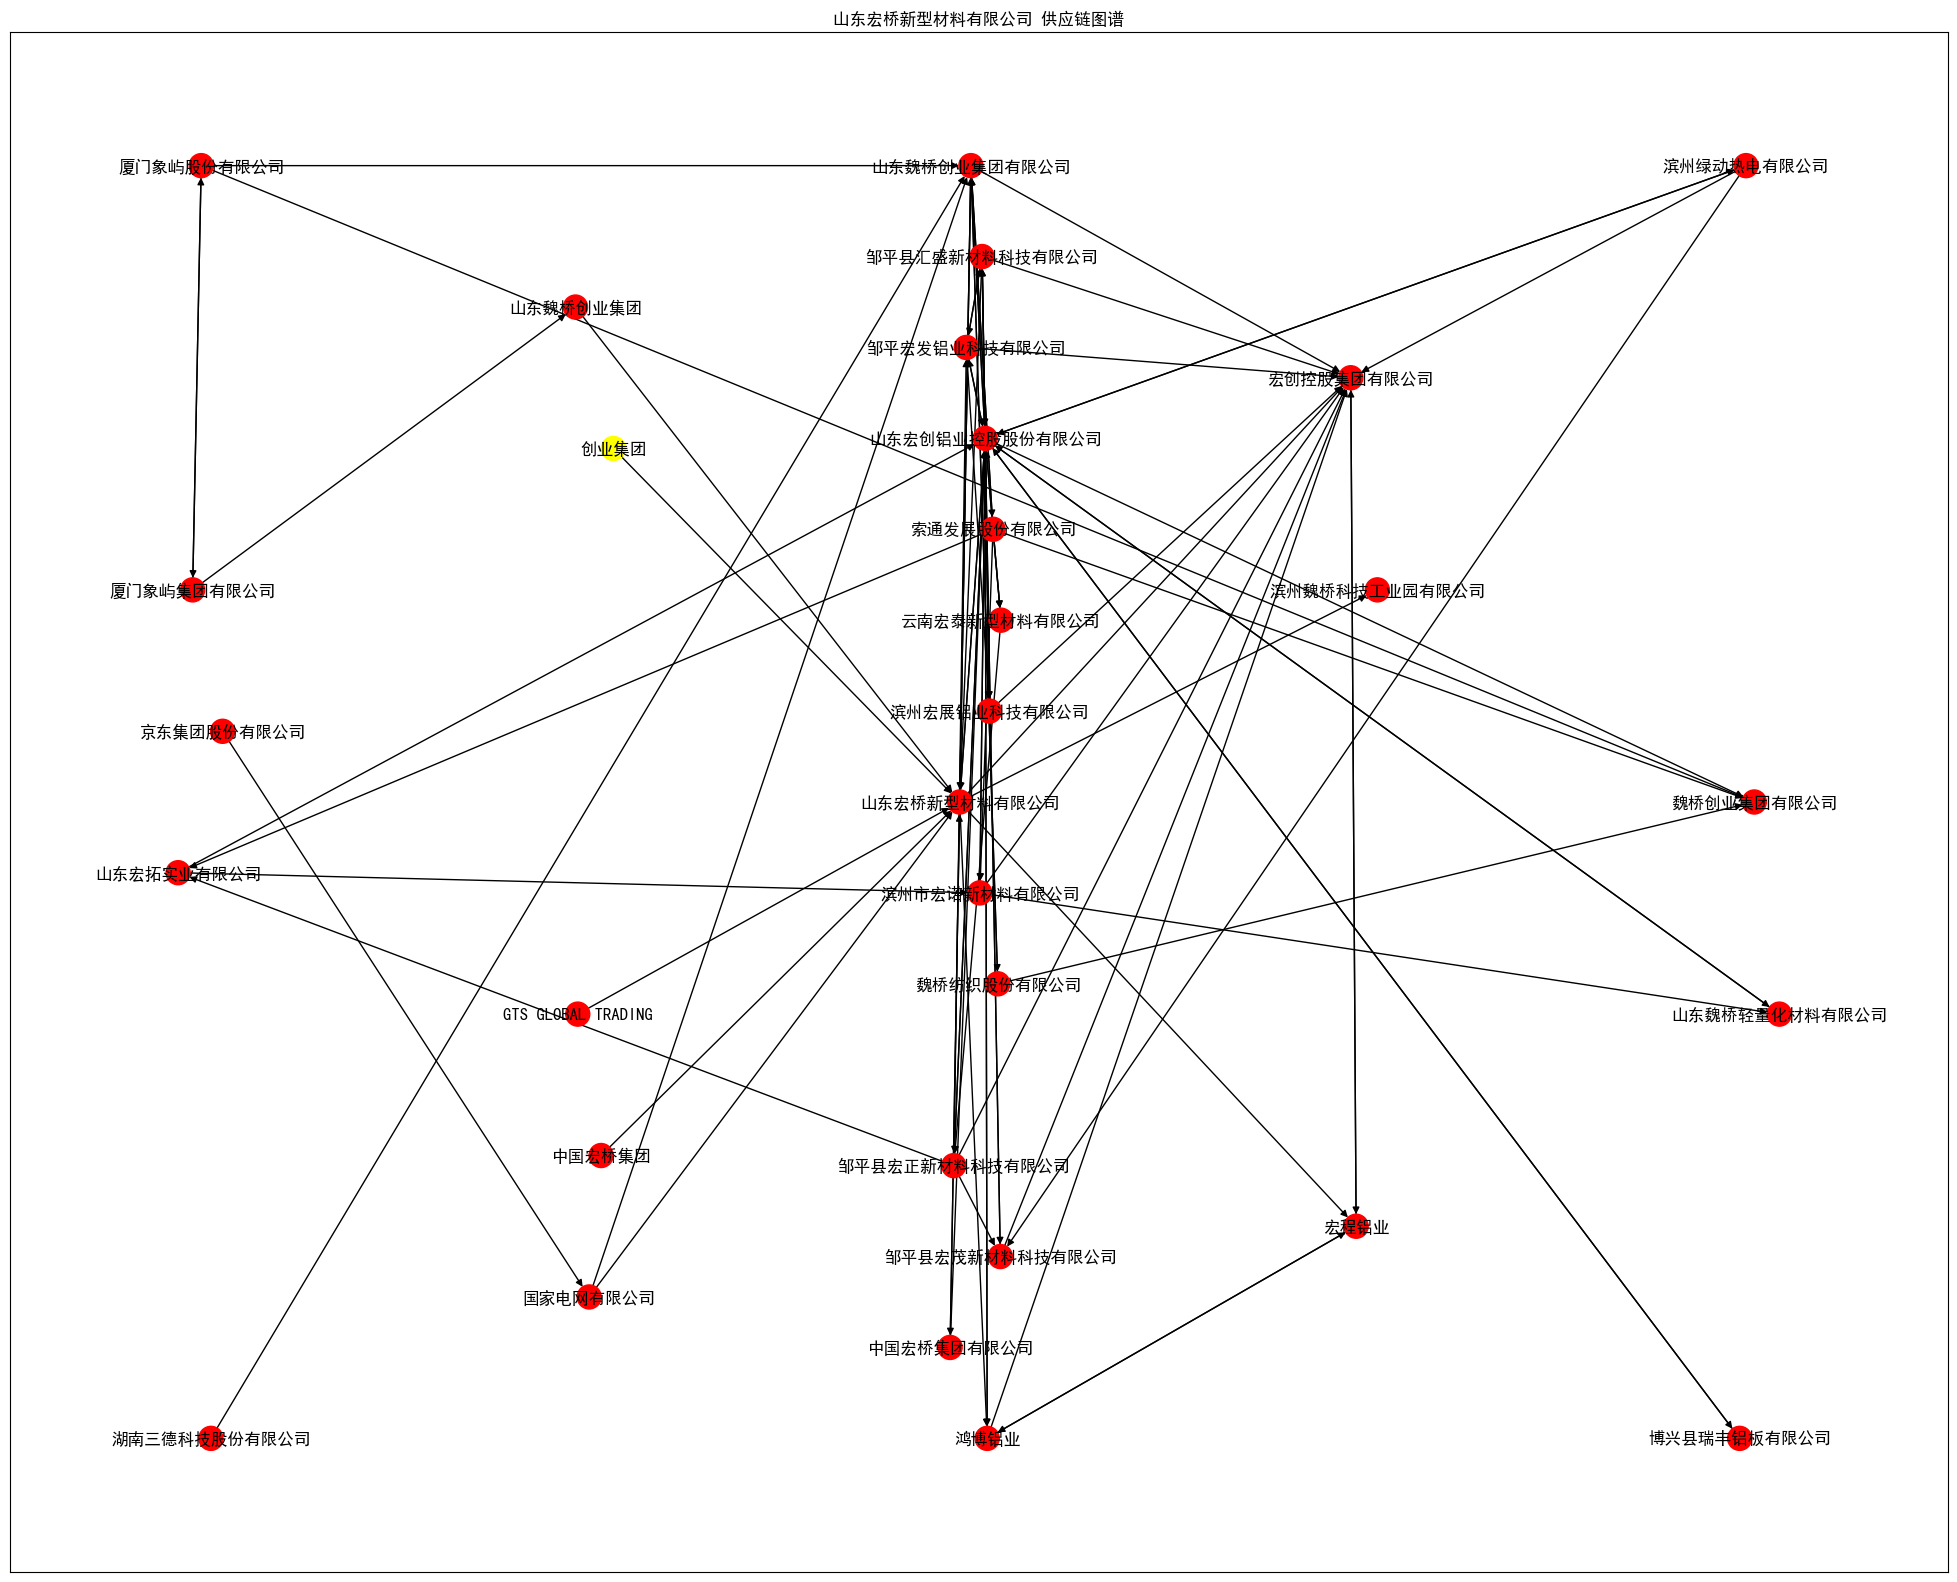

绘图完成，节点列表： ['湖南三德科技股份有限公司', '中国宏桥集团', '邹平县宏茂新材料科技有限公司', '山东魏桥轻量化材料有限公司', '滨州魏桥科技工业园有限公司', '山东宏创铝业控股股份有限公司', '山东魏桥创业集团', '鸿博铝业', '博兴县瑞丰铝板有限公司', '国家电网有限公司', '邹平县宏正新材料科技有限公司', '云南宏泰新型材料有限公司', '京东集团股份有限公司', '邹平宏发铝业科技有限公司', '邹平县汇盛新材料科技有限公司', '山东宏桥新型材料有限公司', '山东宏拓实业有限公司', '滨州宏展铝业科技有限公司', '厦门象屿集团有限公司', '山东魏桥创业集团有限公司', '宏程铝业', '中国宏桥集团有限公司', 'GTS GLOBAL TRADING', '魏桥纺织股份有限公司', '滨州市宏诺新材料有限公司', '魏桥创业集团有限公司', '索通发展股份有限公司', '创业集团', '滨州绿动热电有限公司', '宏创控股集团有限公司', '厦门象屿股份有限公司']


In [4]:
from auxiliary.show import draw_splc_graph
draw_splc_graph("山东宏桥新型材料有限公司", supply_net, fig_size=[25, 20], tier_1_num=50, tier_2_num=20) 

In [5]:
# 将不同级别的连边分别导出

for edge in supply_net.edges():
    edge_info=supply_net.edges[edge]
    cate_list=edge_info["product_category"].split("-")
    
    edge_info["product_category_1"]=cate_list[0] if cate_list else ""
    edge_info["product_category_2"]="-".join(cate_list[:2]) if len(cate_list)>=2 else edge_info["product_category_1"]
    edge_info["product_category_3"]="-".join(cate_list[:3]) if len(cate_list)>=3 else edge_info["product_category_2"]
    edge_info["product_category_4"]=edge_info["product_category"]
    del edge_info["product_category"]
    

In [6]:
nx.write_graphml(supply_net,r"result\魏桥多层级连边染色_test.graphml")

In [ ]:
sub_suplly_net=get_subnetwork(supply_net, [
        "山东宏创铝业控股股份有限公司",
        "山东宏桥新型材料有限公司",
        "山东魏桥创业集团有限公司",
        "魏桥创业集团",
        "魏桥创业集团有限公司",
        "中国宏桥集团有限公司"
    ], 2, tree_structure=False)

In [9]:
nx.write_graphml(sub_suplly_net, r"result\魏桥多层级连边染色_子网络.graphml")

In [ ]:
# 这是导出用的函数在类化之前的单线程版本

import networkx as nx
from tqdm import tqdm

LABEL_PRIORITY = [
    "Media", 
    "MiningSite", 
    "Company",
    "Government",
    "Factory",
    "Academic",
    "NGO",
    "Others",
    "EntityObj"
]

def match_with_priority(label_list, priority_list):
    "带优先级的"
    for label in priority_list:
        if label in label_list:
            return label
    return ""


def export_supply_relations(neo4j_host: API.neo4j_SLPC.Neo4jClient, batch_size=500):
    """导出SupplyProductTo关系并构建网络图"""
    G = nx.DiGraph()
    skip = 0
    relation_counter = {}  # 用于跟踪关系计数
    
    # 进度条初始化
    total = get_total_relations(neo4j_host)
    pbar = tqdm(total=total, desc="导出关系")

    while True:
        # 优化后的Cypher查询（包含关系计数和规范名称处理）
        query = """
            MATCH (n:EntityObj)-[r:SupplyProductTo]->(m:EntityObj)
            where n.rubbish <> true and m.rubbish <> true and r.verified <> "suspected"
            WITH n, m, COUNT(r) AS rel_count
            OPTIONAL MATCH (n)-[:FullNameIs]->(n_full)
            WITH n, m, rel_count, 
                COLLECT(n_full.name) AS n_names
            OPTIONAL MATCH (m)-[:FullNameIs]->(m_full)
            WITH n, m, rel_count, n_names,
                COLLECT(m_full.name) AS m_names
            RETURN 
                COALESCE(
                    REDUCE(longest = n.name, name IN n_names | 
                        CASE WHEN size(name) > size(longest) THEN name ELSE longest END
                    ), n.name) AS supplier,
                COALESCE(n.country, "") as s_country,
                labels(n) as s_labels,
                elementid(n) as s_id,
                COALESCE(
                    REDUCE(longest = m.name, name IN m_names | 
                        CASE WHEN size(name) > size(longest) THEN name ELSE longest END
                    ), m.name) AS customer,
                COALESCE(m.country, "") as c_country,
                labels(m) as c_labels,
                elementid(m) as c_id,
                rel_count
            ORDER BY supplier, customer
            SKIP $skip LIMIT $limit
        """
        params = {"skip": skip, "limit": batch_size}
        batch = neo4j_host.execute_query(query, parameters=params)
        
        if not batch:
            break
            
        # 处理当前批次
        for record in batch:
            supplier = record["supplier"]
            s_country=record["s_country"]
            s_labels=record["s_labels"]
            s_id=record["s_id"]
            customer = record["customer"]
            c_country=record["c_country"]
            c_labels=record["c_labels"]
            count = record["rel_count"]
            c_id=record["c_id"]
            
            # 验证不是垃圾节点
            if sql_host.check_item_exists(table_name="rubbish_nodes", item=supplier):
                neo4j_host.execute_query("match (n) where elementid(n)=$id set n.rubbish=true",parameters={"id":s_id})
                continue
            if sql_host.check_item_exists(table_name="rubbish_nodes", item=customer):
                neo4j_host.execute_query("match (n) where elementid(n)=$id set n.rubbish=true",parameters={"id":c_id})
                continue
            
            # 更新网络图
            # 使用元组作为关系标识
            rel_key = (supplier, customer)
            
            # 累加关系计数
            current_count = relation_counter.get(rel_key, 0)
            new_count = current_count + count
            relation_counter[rel_key] = new_count
            
            # 更新网络边权重
            if G.has_edge(supplier, customer):
                G[supplier][customer]['count'] = new_count
            else:
                G.add_edge(supplier, customer, count=new_count)
                
            # 确保节点存在
            G.add_node(supplier, country=s_country, type=match_with_priority(s_labels, LABEL_PRIORITY))
            G.add_node(customer, country=c_country, type=match_with_priority(c_labels, LABEL_PRIORITY))
            
        skip += batch_size
        pbar.update(len(batch))
    
    pbar.close()
    return G

def get_total_relations(neo4j_host):
    """获取总关系数用于进度条"""
    query = "MATCH ()-[r:SupplyProductTo]->() RETURN COUNT(r) AS total"
    result = neo4j_host.execute_query(query)
    return result[0]["total"] if result else 0

# 使用示例
if __name__ == "__main__":
    from API.neo4j_SLPC import Neo4jClient
    
    neo4j_host = Neo4jClient(driver=API.neo4j_SLPC.local_driver)
    supply_graph = export_supply_relations(neo4j_host)
    
    # 输出统计信息
    print(f"节点数量: {len(supply_graph.nodes())}")
    print(f"关系数量: {len(supply_graph.edges())}")

导出关系:  31%|███       | 1671/5463 [02:01<04:36, 13.74it/s]

节点数量: 1509
关系数量: 1598
Top 10 供应商关系:
深圳华大智造科技股份有限公司 -> 深圳华大基因股份有限公司 (权重: 35)
厦门象屿股份有限公司 -> 厦门象屿集团有限公司 (权重: 22)
山东宏桥新型材料有限公司 -> 山东宏创铝业控股股份有限公司 (权重: 20)
邹平县宏正新材料科技有限公司 -> 山东宏创铝业控股股份有限公司 (权重: 19)
厦门象屿股份有限公司 -> 厦门象盛镍业有限公司 (权重: 15)
深圳华大智造科技股份有限公司 -> 青岛华大基因研究院 (权重: 14)
邹平宏发铝业科技有限公司 -> 山东宏创铝业控股股份有限公司 (权重: 14)
深圳华大智造科技股份有限公司 -> 深圳华大生命科学研究院 (权重: 13)
河南神火集团新利达有限公司 -> 河南神火煤电股份有限公司 (权重: 10)
滨州绿动热电有限公司 -> 山东宏创铝业控股股份有限公司 (权重: 10)


In [16]:
len(supply_graph.nodes)

1509